# Random Forest Classifier or Regressor: Which to choose?
> A basic comparison of predictions when using an off the shelf sklearn classifier verus regressor, with different criterion to split decision trees. The data is taken from the Homesite Competition on Kaggle . N.B. Minimal exploratory data analysis & quality control.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png
- author: Owen

This notebook compares 2 basic Random Forest models, each with 2 different criterion to split decision trees. Distributions of predicitons are plotted at the end. Rather than provide any concrete conclusions, I leave this here as food for thought.

## Setup Working Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 32.3 MB/s 
     |████████████████████████████████| 60 kB 8.7 MB/s 
     |████████████████████████████████| 1.2 MB 46.9 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 188 kB 54.9 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 335 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [7]:
Path.cwd()

Path('/content')

In [8]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/GroupProject')
path = Path.cwd()
path

Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject')

We should now have all the functions we require to run the notebook. The next thing we need is our dataset... 

## Kaggle Dataset

I have previosuly downloadeded the dataset from kaggle, and extracted the files. My teammate Nissan has already described how to [download Kaggle data](https://redditech.github.io/team-fast-tabulous/jupyter/collab/2021/06/19/Get-Kaggle-Data.html). So lets check the files listed in the directory:

In [9]:
path.ls()

(#5) [Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject/RegressorVersusClassifier.ipynb'),Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject/predictions'),Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject/_data'),Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject/.ipynb_checkpoints'),Path('/content/gdrive/MyDrive/Colab Notebooks/GroupProject/notebook.ipynb')]

In [12]:
train = pd.read_csv(path/'_data/train.csv',low_memory=False)
test = pd.read_csv(path/'_data/test.csv',low_memory=False)

## Minimal Data Exploration

Only presenting basic steps here. My teammates have provided other notebooks on more detailed EDA.

In [13]:
train.shape,train.columns

((260753, 299),
 Index(['QuoteNumber', 'Original_Quote_Date', 'QuoteConversion_Flag', 'Field6',
        'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12',
        ...
        'GeographicField59A', 'GeographicField59B', 'GeographicField60A',
        'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
        'GeographicField62A', 'GeographicField62B', 'GeographicField63',
        'GeographicField64'],
       dtype='object', length=299))

train.shape tells us that there are 260,753 rows, and 299 columns of data in the training set. To look at the column names specifically we can use train.columns, which also confirms there are 299 columns.

In [14]:
test.shape,test.columns

((173836, 298),
 Index(['QuoteNumber', 'Original_Quote_Date', 'Field6', 'Field7', 'Field8',
        'Field9', 'Field10', 'Field11', 'Field12', 'CoverageField1A',
        ...
        'GeographicField59A', 'GeographicField59B', 'GeographicField60A',
        'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
        'GeographicField62A', 'GeographicField62B', 'GeographicField63',
        'GeographicField64'],
       dtype='object', length=298))

test.shape tells us that there are fewer records in the test set compared to the training set (260,753 vs. 173,753), and one less column (299 vs 298). The missing column is our dependent variable, "QuoteConversion_Flag".

The output from .columns also shows that we have a variable containing dates in the 2nd column - "Original_Quote_Date". Numerical coding of the date, although easy to read, hides potentially valuable information about dates. Such as: which day of the week? Was it a holiday? Is this date closer to the start or end of the calendar/financial year? This information could have an influence on what we are trying to predict. Thankfully, fast.ai has provided a useful function that takes the numerical date format and generates extra columns that hold this sort of information. Lets give it a go and have a look at the output. 

In [15]:
train = add_datepart(train, 'Original_Quote_Date')
train.columns

Index(['QuoteNumber', 'QuoteConversion_Flag', 'Field6', 'Field7', 'Field8',
       'Field9', 'Field10', 'Field11', 'Field12', 'CoverageField1A',
       ...
       'Original_Quote_Day', 'Original_Quote_Dayofweek',
       'Original_Quote_Dayofyear', 'Original_Quote_Is_month_end',
       'Original_Quote_Is_month_start', 'Original_Quote_Is_quarter_end',
       'Original_Quote_Is_quarter_start', 'Original_Quote_Is_year_end',
       'Original_Quote_Is_year_start', 'Original_Quote_Elapsed'],
      dtype='object', length=311)

In [16]:
test = add_datepart(test, 'Original_Quote_Date') #Run once
test.columns

Index(['QuoteNumber', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10',
       'Field11', 'Field12', 'CoverageField1A', 'CoverageField1B',
       ...
       'Original_Quote_Day', 'Original_Quote_Dayofweek',
       'Original_Quote_Dayofyear', 'Original_Quote_Is_month_end',
       'Original_Quote_Is_month_start', 'Original_Quote_Is_quarter_end',
       'Original_Quote_Is_quarter_start', 'Original_Quote_Is_year_end',
       'Original_Quote_Is_year_start', 'Original_Quote_Elapsed'],
      dtype='object', length=310)

By calling .columns once again, we can see we now have 311 (training) and 310 (test) columns with info about the day of week, day of year, holiday, etc. 

In [17]:
train['QuoteConversion_Flag'].unique()
train['QuoteConversion_Flag'].describe()
dep_var = 'QuoteConversion_Flag'

## Sample Training and Validation Sets from Train DF

Before we run our models, we need to split our trainging dataframe into a training set and a validation set. The validation set will not be passed to the model for training, and will provide us metrics for how well our model generalises to 'unseen' data. For a first attempt, lets randomly assign 80% of our records to the training set and 20% of our records to the validation set.

In [19]:
dep_var = 'QuoteConversion_Flag'
cont,cat = cont_cat_split(train, 1, dep_var=dep_var) #Specify Continuous & Categorical Columns in the DataSe
#cont,cat,dep_var
procs = [Categorify,FillMissing]

In [25]:
random.seed(42)
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [26]:
to = TabularPandas(train,procs,cat,cont,y_names=dep_var,splits=splits)

In [27]:
len(to.train),len(to.valid)

(166882, 41720)

In [28]:
#Assign Trianing & Validation Records
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Random Forest Classifier

Looking at the dependent variable - "QuoteConversion_Flag", we can seen that this is a binary outcome, i.e 0 or 1. The obvious choice when using Decision Trees with binary data is a Random Forest Classifier. In the classifier, each tree votes and the most popular class is chosen as the final result.

### Split Trees by Gini Impurity

In [29]:
#Run Random Forest Classifier
rfclass_gini = RandomForestClassifier(n_jobs=-1, random_state=42, criterion = "gini",oob_score=False).fit(xs, y)

In [30]:
#Get predictions from Classifier for Training & Validation Sets 
train_classifier_gini_predictions = rfclass_gini.predict(xs)
valid_classifier_gini_predictions = rfclass_gini.predict(valid_xs)

The output from the Classifier are binary predictions. See below:

(array([36157.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,  5563.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

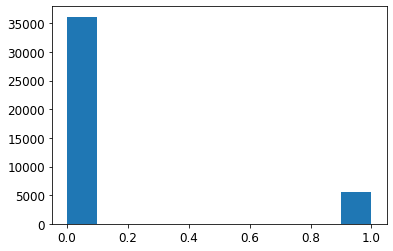

In [31]:
#Plot range of predictions for validation Set
plt.hist(valid_classifier_gini_predictions, bins=10)

To get the probabilities of each outcome; whether a customer purchases insurance (1) or not (0), we need to call a different function

(array([[  734.,  1265.,  1128.,   959.,  1477.,  2554.,  2551.,  2570.,  4729., 23753.],
        [23058.,  5109.,  3174.,  2262.,  2380.,  1651.,  1056.,   919.,  1253.,   858.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

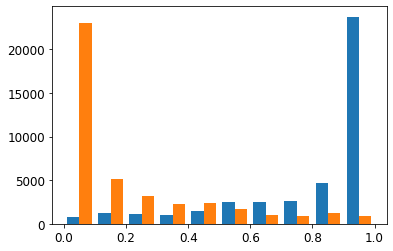

In [32]:
#predictions probabilites of outcomes for validation Set
rfclass_gini.predict_proba(valid_xs)
plt.hist(rfclass_gini.predict_proba(valid_xs), bins=10)

We can see the output is a probability for each class. So in this case we have 2 probabilty estimates for each record. However, the Kaggle competition compares entries on the area under the curve (AUC). Therefore, lets see how the classifier performs for this metric. 

In [33]:
#Print ROC AUC Score
train_classifier_auc = roc_auc_score(y,train_classifier_gini_predictions)
valid_classifier_auc = roc_auc_score(valid_y,valid_classifier_gini_predictions)
train_classifier_auc,valid_classifier_auc

(1.0, 0.8046764979102705)

For a first model, without any feature selection and data cleaning an ROC AUC of 0.81 in the validation isnt bad. A model predicting outcomes randomly would produce an ROC AUC of 0.5. The code below shoes this:

In [34]:
random_probs = [0 for _ in range(len(valid_y))]
random_lr_auc = roc_auc_score(valid_y, random_probs)
random_lr_auc

0.5

We can see that the random forest classfier is doing a lot better than a model making random predcitions, so that is encouraging.

Another way of visualising the results from classification tasks is a confusion matrix. This plots the counts of the predicted vs true classes. This Classifier seems to do a relatively good job at predicting records that relate to customers who did not purchase home insurance (True = 0), but struggled a lot more at predicting records that relate to customers that did go onto purchase home insurance (True = 1). Another observation is that is a skew in the number of records towaards those of customers that did NOT go onto purchase home.

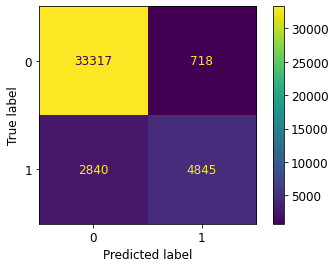

In [35]:
plot_confusion_matrix(rfclass_gini,valid_xs, valid_y,values_format='d')
plt.show()

### Split Trees by Entropy

The Random Forest Classifier has a second option for the criteria used to split the decision trees. Lets try the same process with the 'entropy' criterion and compare the results.

In [36]:
rfclass_entropy = RandomForestClassifier(n_jobs=-1, random_state=42, criterion = "entropy",oob_score=False).fit(xs, y)
train_classifier_entropy_predictions = rfclass_entropy.predict(xs)
valid_classifier_entropy_predictions = rfclass_entropy.predict(valid_xs)

In [37]:
#Print ROC AUC Score
roc_auc_score(y,train_classifier_entropy_predictions),roc_auc_score(valid_y,valid_classifier_entropy_predictions)

(1.0, 0.8035137773421845)

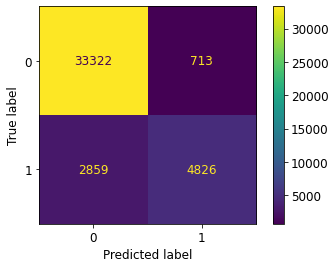

In [38]:
plot_confusion_matrix(rfclass_entropy,valid_xs, valid_y,values_format='d')
plt.show()

Comparing the confusion matrices gives us an indication of how the different criterion influenced the predictions from the classifiers.

The 'entropy' criterion looks as though it did very slightly better at classfying records in which customers did not purchase home insurance (True Label = 0_, and slightly worse than the 'gini impurity' for records in which customers did go on to purchase home insurance (True Label = 1). 

Given the task is to predict the probabilty that a customer went onto purchase home insurance, using the 'gini impurity' criterion seems more appropriate. Although given such as small difference between criterion, the decision between these two criterion is lilkey to have very little influence on the results of the model overall. Therefore, time investigating the effect of removing redundant or highly correlated variablesmay be more fruitful.

## Create Random Forest Regressor

Although I said a Random Forest Classifier is the most obvious choice for use on binary data, we could try something else. The Kaggle competition task is to predict the probability that a customer purchased home insurance. Therefore, why not use a method that directly outputs probabilities. 

In short: 

A classifier will take the most common prediction from all of the decision trees. So if we run 100 trees, and 51 predict the customer purchased home insurance (1), and 49 predicted that the customer did NOT purchase home insurance (0), the overall prediction would be that the customer purchased home insurance (1). Since, we just want a probability, not a classification for the task, why force the model to make a classification. This could hae a particularly big imapct in the intermediate cases, as above.

Why not try a regressor? a Random Forest Regressor will take the average of the predictions from all of the decision trees. Therefore, in the example above, the overall prediction would be 0.51. This prediciton could be passed directly to the Kaggle to compute the ROC AUC score. Using this more conservative approach could provide improvements for these intermediate cases. So lets try it!

In [ ]:
rfregress_mse = RandomForestRegressor(n_jobs=-1,random_state=42,criterion="mse",oob_score=False).fit(xs, y)
train_rfregress_mse_predictions = rfregress_mse.predict(xs)
valid_rfregress_mse_predictions = rfregress_mse.predict(valid_xs)

In [ ]:
train_lr_auc = roc_auc_score(y, train_rfregress_mse_predictions)
valid_lr_auc = roc_auc_score(valid_y, valid_rfregress_mse_predictions)
train_lr_auc,valid_lr_auc

With the Regressor, using defult parameters and splitting trees based on the Mean Squared Error (mse), we get over a 10% increase in the ROC AUC for the validation set! (Caveat, This difference may be less after more detailed EDA and QC)

Lets re-check the Classifier ROC AUC to be sure:

In [ ]:
train_classifier_auc,valid_classifier_auc

(1.0, 0.8121955713748932)

I will leave investigating the reasons for the differences for another notebook, this could involve writing our own classifiers and regressors so me can compare with the same or different loss functions. But to show the differences in the outputs of the two models, histograms of the predictions from the Random Forest Classifier & and the Random Forest Regressor are shown below:

#### Classifier

(array([12171.,  4645.,  2879.,  2036.,  1653.,  1305.,  1154.,  1094.,  1000.,   931.,   854.,   756.,   733.,   667.,   597.,   587.,   532.,   452.,   496.,   457.,   400.,   399.,   360.,   398.,
          371.,   352.,   323.,   347.,   340.,   346.,   323.,   326.,   319.,   317.,   612.,     0.,   302.,   311.,   317.,   314.,   634.,     0.,   282.,   271.,   263.,   276.,   532.,     0.,
          257.,   251.,   218.,   227.,   229.,   212.,   203.,   181.,   396.,     0.,   187.,   175.,   147.,   184.,   159.,   147.,   159.,   167.,   129.,   131.,   286.,   127.,     0.,   136.,
          140.,   125.,   115.,   128.,   128.,   130.,   154.,   158.,   129.,   325.,   157.,     0.,   147.,   175.,   168.,   158.,   156.,   181.,   160.,   178.,   149.,   302.,   106.,     0.,
           93.,    73.,    35.,    38.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 

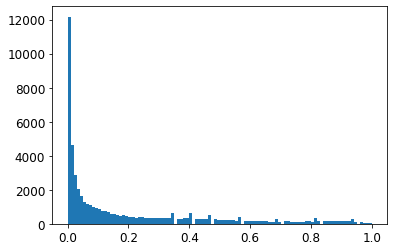

In [ ]:
plt.hist(rfclass_gini.predict_proba(valid_xs)[:,1], bins=100,range=[0, 1])

#### Regressor

(array([21304.,  2296.,  1756.,  1427.,  1255.,  1147.,   984.,   918.,   748.,   744.,   646.,   594.,   565.,   473.,   456.,   434.,   441.,   379.,   363.,   349.,   366.,   324.,   312.,   329.,
          283.,   327.,   286.,   274.,   240.,   237.,   242.,   210.,   276.,   239.,   519.,     0.,   228.,   223.,   228.,   179.,   387.,     0.,   210.,   214.,   191.,   167.,   314.,     0.,
          159.,   186.,   139.,   148.,   131.,   127.,   122.,   136.,   195.,     0.,   103.,    94.,    93.,    75.,    76.,    73.,    64.,    59.,    61.,    57.,    87.,    47.,     0.,    45.,
           44.,    32.,    33.,    32.,    31.,    35.,    32.,    36.,    33.,    45.,    26.,     0.,    22.,    25.,    26.,    34.,    31.,    28.,    39.,    44.,    42.,   117.,    83.,     0.,
           91.,   147.,   232.,  4449.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 

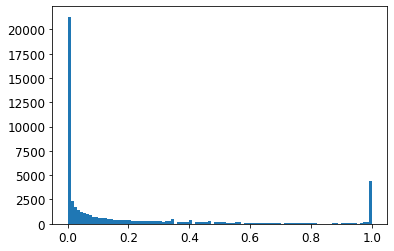

In [ ]:
plt.hist(valid_rfregress_mse_predictions, bins=100,range=[0, 1])

##  Test Set Predictions

#### Data Prep

In [ ]:
cont,cat = cont_cat_split(test, max_card=1000) #Specify Continuous & Categorical Columns in the DataSe
procs = [Categorify,FillMissing]

In [ ]:
to.test = TabularPandas(test,procs,cat,cont,splits=None)
to.test.show()

,Field6,Field7,Field10,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicField36B,GeographicField37A,GeographicField37B,GeographicField38A,GeographicField38B,GeographicField39A,GeographicField39B,GeographicField

In [ ]:
#Create Test X's object
test_xs = to.test.xs

#### Predictions

In [ ]:
#Probability of Insurance Policy Purchased - Classifier
test_classifier_gini_predictions = rfclass_gini.predict_proba(test_xs)
#Probability of Insurance Policy Purchased - Regressor 
test_rfregress_mse_predictions  = rfregress_mse.predict(test_xs)

In [ ]:
#submitting output
classifier_submission = pd.DataFrame(zip(test.QuoteNumber,test_classifier_gini_predictions), columns = ['QuoteNumber','QuoteConversion_Flag'])
classifier_submission.to_csv(path/'classifier_submission.csv',index=False)

regressor_submission = pd.DataFrame(zip(test.QuoteNumber,test_rfregress_mse_predictions), columns = ['QuoteNumber','QuoteConversion_Flag'])
regressor_submission.to_csv(path/'regressor_submission.csv',index=False)